In [5]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from functools import partial

# !pip install pkbar
# !pip install wandb
import pkbar

!pip install potatorch

import potatorch
from potatorch.training import TrainingLoop, make_optimizer
from potatorch.callbacks import ProgressbarCallback
from potatorch.optimization.tuning import HyperOptimizer
from torch.utils.data import TensorDataset

Defaulting to user installation because normal site-packages is not writeable


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## Dataset loading



In [6]:
df = pd.read_csv('./NARMA10.csv', header=None)
print(df.head())

       0        1        2        3        4         5        6         7      
0  0.083964  0.48934  0.35635  0.25024  0.23554  0.029809  0.34099  0.021216  \
1  0.000000  0.00000  0.00000  0.00000  0.00000  0.000000  0.00000  0.000000   

       8        9     ...     9990     9991     9992     9993     9994   
0  0.035723  0.26082  ...  0.08209  0.19951  0.26618  0.43761  0.32952  \
1  0.000000  0.00000  ...  0.26495  0.21299  0.26849  0.19633  0.32609   

      9995      9996     9997     9998      9999  
0  0.39381  0.063013  0.26249  0.44974  0.054542  
1  0.31816  0.448240  0.26351  0.20217  0.365350  

[2 rows x 10000 columns]


## Architecture



In [7]:
class TDNN(nn.Module):
    def __init__(self, window=1, num_layers=1, dim = 512, out_dim = 1, pad=True, **kwargs):
        super().__init__()
        
        self.window = window
        self.pad = pad
        
        layers = []
        for layer in range(num_layers):
            layers.append(nn.LazyLinear(dim))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(dim, out_dim))
        
        self.tdnn = nn.Sequential(
            *layers
        )
        
    def forward(self, x):
        if self.pad:
            x = F.pad(x, pad=(self.window-1, 0), mode='constant', value=0.0)
        x = x.unfold(dimension=0, size=self.window, step=1)
        return self.tdnn(x)
    
    
class StatefulRNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.rnn = nn.RNN(*args, **kwargs)
        self.b_multiplier = 2 if self.rnn.bidirectional else 1
        self.readout = nn.Linear(self.rnn.hidden_size * self.b_multiplier, self.rnn.input_size)
        self.reset_state()
    
    def forward(self, x):
        x = x.unsqueeze(1)
        self.h0 = self.h0.to(x.device)
        
        y, h = self.rnn(x, self.h0)
        y = self.readout(y)
        self.h0 = h.detach()
        return y
    
    def reset_state(self):
        self.h0 = torch.zeros(self.rnn.num_layers * self.b_multiplier, self.rnn.hidden_size)


## Training Loop



In [8]:
def set_deterministic(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    # torch.backends.cudnn.benchmark = True
    # torch.use_deterministic_algorithms(True)

def pad_left(ds, length):
    return np.pad(ds, ((0, 0), (length, 0)), mode='constant')

In [9]:
class HistoryLoggerCallback(potatorch.callbacks.TrainingCallback):
    """ Track training history """
    def __init__(self, history):
        self.history = history
        super().__init__()
     
    def state_dict(self):
        return None
    
    def load_state_dict(self):
        pass
    
    def on_train_epoch_end(self, state):
        self.history.append(state.get_last_metrics())
    
    def on_train_start(self, state):
        self.history.clear()

In [10]:
def train_TDNN(dataset, device, config, return_history=False):
    epochs = config['epochs']
    
    model = TDNN(**config, pad=False)
    
    loss_fn = lambda y, y_true: torch.nn.MSELoss()(y, y_true[(config['window'] - 1):])
    optimizer = make_optimizer(torch.optim.Adam, lr = config['lr'])
    history = []
    
    training_loop = TrainingLoop(
        dataset,
        loss_fn,
        optimizer,
        train_p = 0.4,
        val_p = 0.1,
        test_p = 0.5,
        random_split = False,
        batch_size = None,
        shuffle = False,
        device = device,
        num_workers = 0,
        seed = 42,
        callbacks = [
            ProgressbarCallback(epochs=epochs, width=20),
            HistoryLoggerCallback(history)
        ]
    )
    training_loop.run(model, epochs = epochs, verbose = config.get('verbose', 0))
    if return_history:
        return training_loop, history
    return training_loop

In [11]:
def prediction_plot(training_loop, window=0):
    metrics = training_loop.evaluate()
    t = range(100)
    print(f"Test loss: {metrics['loss']}")
    
    y = training_loop.predict([d[0] for d in training_loop.test_dataloader])
    y_true = [d[1].numpy() for d in training_loop.test_dataloader][0][max(window-1, 0):len(t)+window]

    plt.plot(t, y[:len(t)], label='prediction')
    plt.plot(range(len(y_true)), y_true, label='ground truth')
    plt.legend()
    plt.show()

## TDNN Model Selection



### Sweep configuration



In [12]:
tdnn_sweep_config = {
    'method': 'bayes',
    'iterations': 25,
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'num_layers': {
            'distribution': 'uniform',
            'min': 1,
            'max': 5
        },
        'dim': {
            'distribution': 'uniform',
            'min': 32,
            'max': 1024
        },
        'lr': {
            'distribution': 'log_uniform',
            'min': -4.0,
            'max': -3.0
        },
        'epochs': {
            'distribution': 'uniform',
            'min': 100,
            'max': 500
        }
    },
    'fixed': {
        'window': 11,
        'verbose': 0
    }
    
}

In [13]:
device = 'cuda'
dataset = TensorDataset(torch.from_numpy(df.values[0, :]), torch.from_numpy(df.values[1, :]))
score_function = lambda config: train_TDNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(tdnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 78, 'lr': 0.00031470324163945817, 'epochs': 466}


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 936, 'lr': 0.0009047113513728746, 'epochs': 225}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 790, 'lr': 0.0003252919031010223, 'epochs': 393}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 433, 'lr': 0.0005617837886731182, 'epochs': 131}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 617, 'lr': 0.00030565090373625177, 'epochs': 167}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 184, 'lr': 0.00039638795579049276, 'epochs': 271}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 191, 'lr': 0.00021937548553367206, 'epochs': 461}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 277, 'lr': 0.00018222793533303723, 'epochs': 388}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 737, 'lr': 0.0009423102293208815, 'epochs': 113}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 82, 'lr': 0.0003551905394932458, 'epochs': 112}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 178, 'lr': 0.000832998786850015, 'epochs': 302}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 287, 'lr': 0.00040840481111604116, 'epochs': 463}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 987, 'lr': 0.00036854968615081615, 'epochs': 404}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 993, 'lr': 0.00023592601611054686, 'epochs': 282}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 955, 'lr': 0.0001728242837708687, 'epochs': 397}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 985, 'lr': 0.0003179253342566241, 'epochs': 424}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 630, 'lr': 0.00010493416704622848, 'epochs': 151}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 374, 'lr': 0.0004815821013718266, 'epochs': 489}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 184, 'lr': 0.00018004952725236834, 'epochs': 315}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 821, 'lr': 0.0001557766228248657, 'epochs': 254}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 535, 'lr': 0.0002691319295502523, 'epochs': 466}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 392, 'lr': 0.00012503982175343125, 'epochs': 281}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 714, 'lr': 0.000708216973657929, 'epochs': 331}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 1024, 'lr': 0.000738067014287118, 'epochs': 490}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 945, 'lr': 0.0005741272915342111, 'epochs': 493}


Best configuration found: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 985, 'lr': 0.0003179253342566241, 'epochs': 424}
 with error: 1.2803650861314964e-05


Test loss: 1.1809116585936863e-05


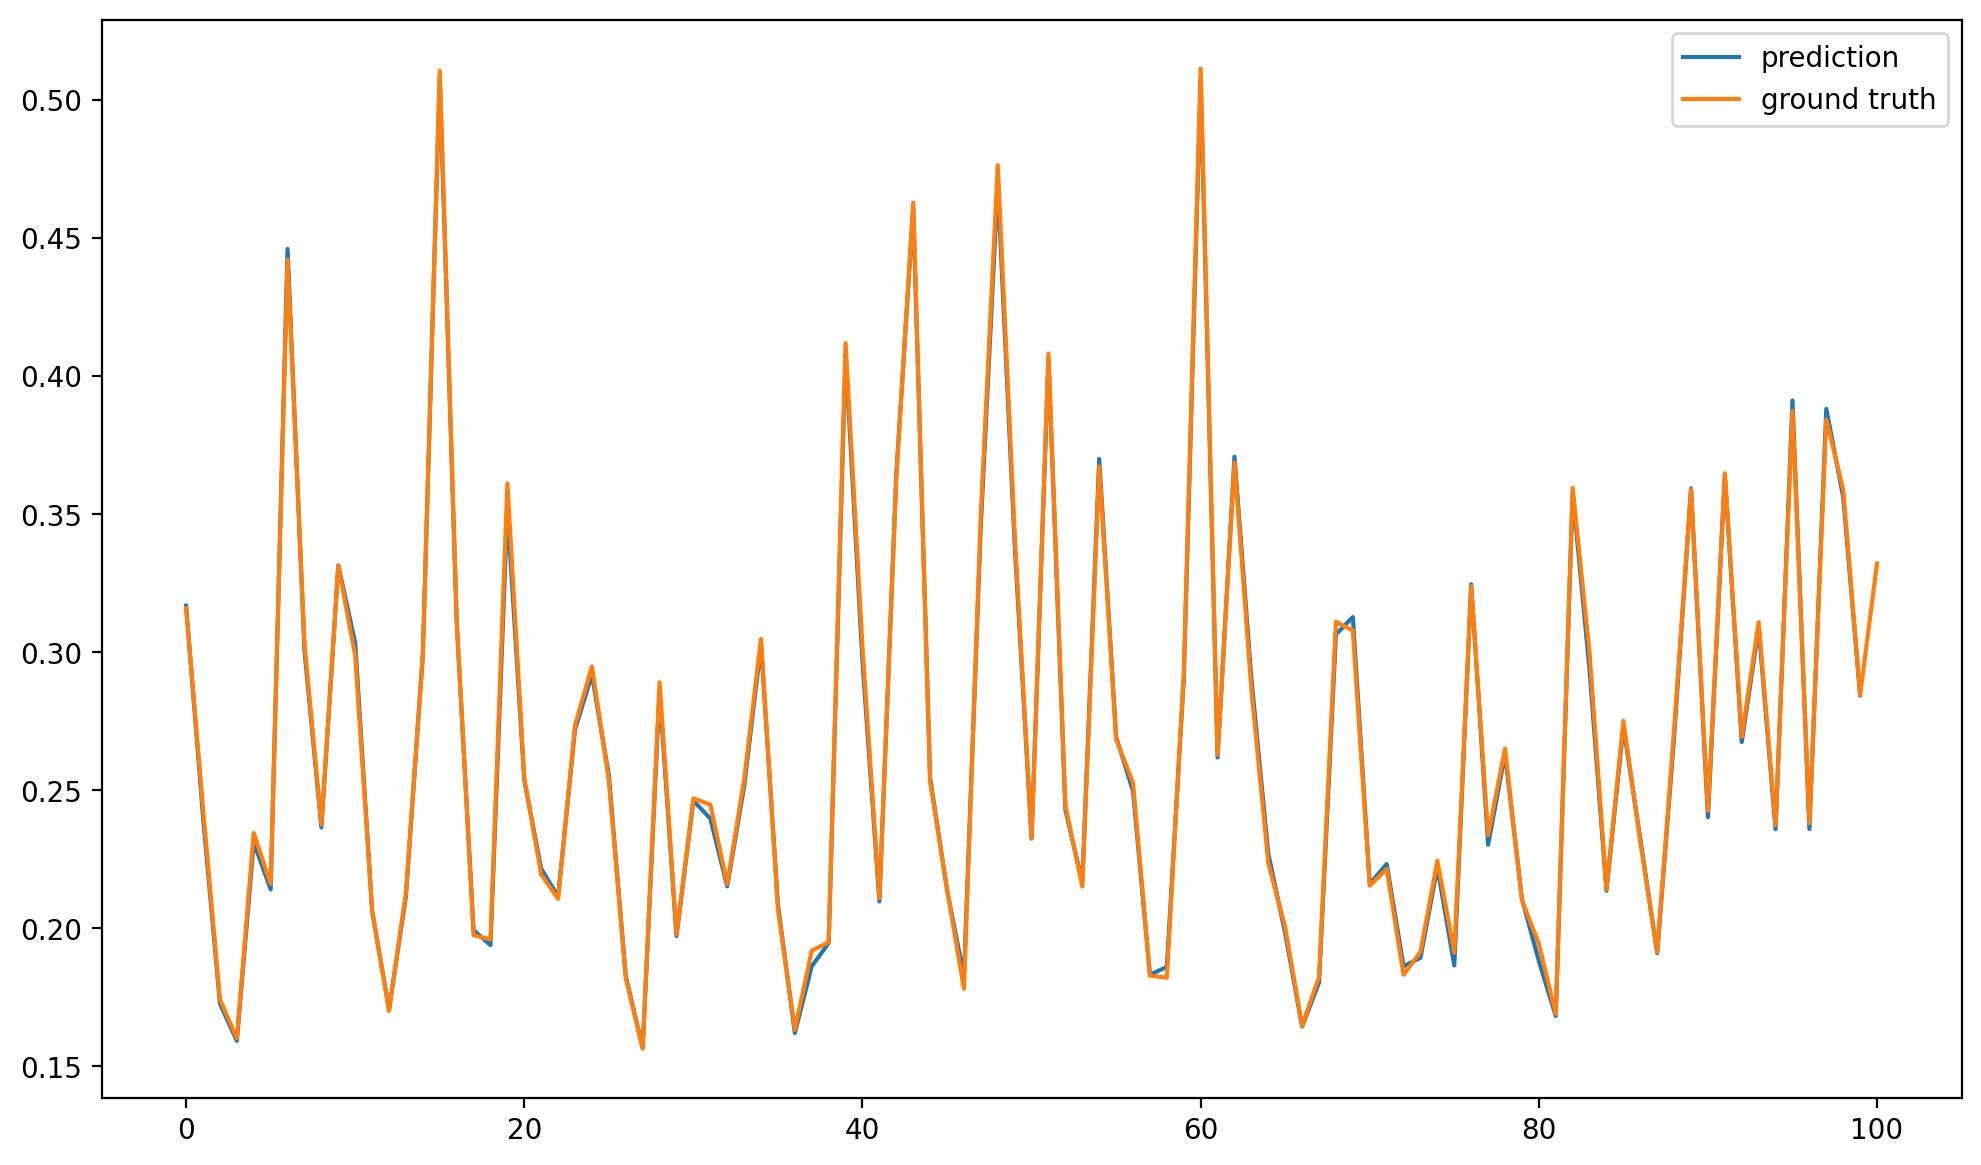

In [14]:
training_loop, history = train_TDNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, best_config['window'])

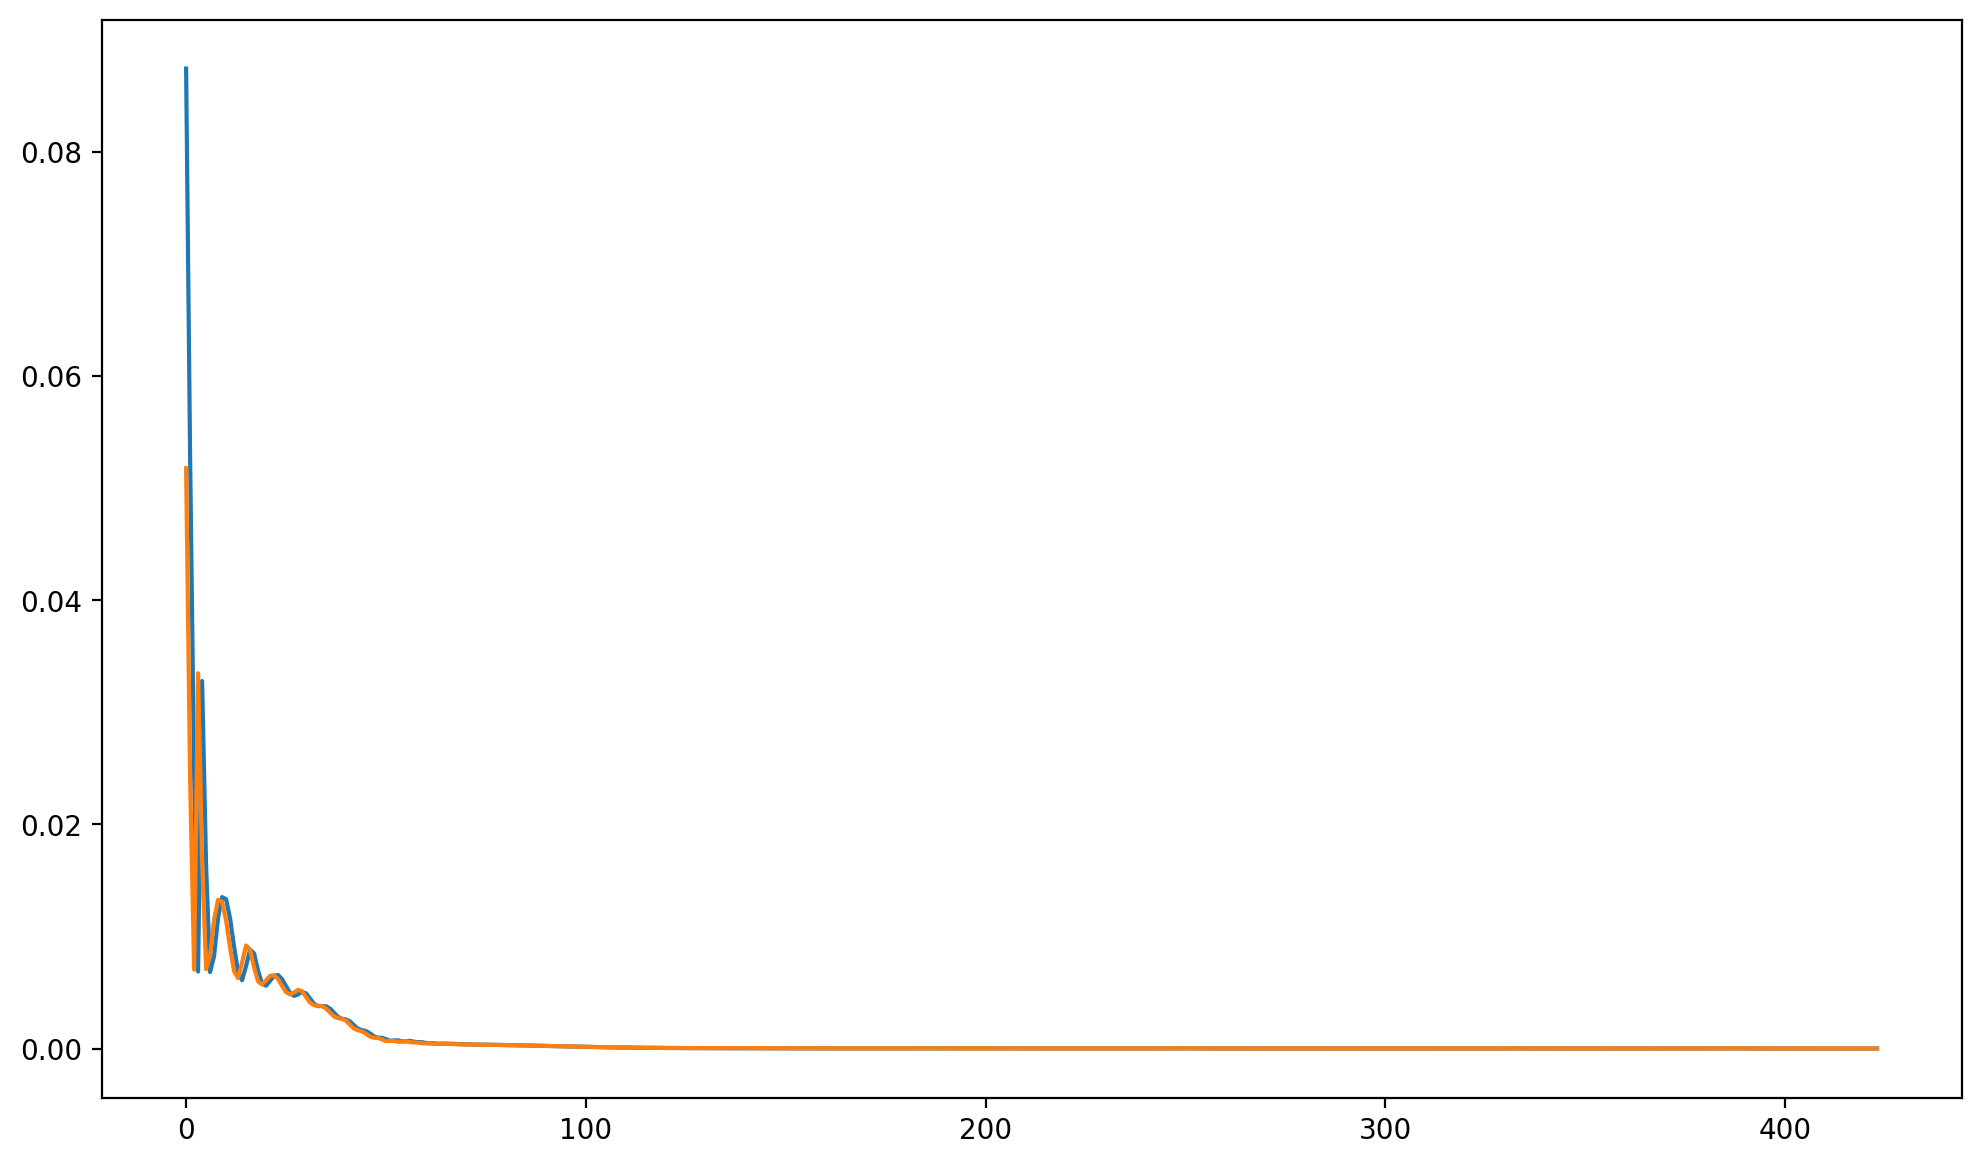

In [15]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.show()

## RNN Model Selection



### Sweep Configuration



In [16]:
rnn_sweep_config = {
    'method': 'bayes',
    'iterations': 10,
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'num_layers': {
            'distribution': 'uniform',
            'min': 1,
            'max': 3
        },
        'hidden_size': {
            'distribution': 'uniform',
            'min': 8,
            'max': 256
        }
    },
    'fixed': {
        'lr': 1e-3,
        'input_size': 1,
        'epochs': 100,
        'verbose': 0
    }
}


In [17]:
def train_RNN(dataset, device, config, return_history=False):
    epochs = config['epochs']
    model = StatefulRNN(num_layers=config['num_layers'], hidden_size=config['hidden_size'], input_size=config['input_size'])
    
    loss_fn = torch.nn.MSELoss()
    optimizer = make_optimizer(torch.optim.Adam, lr = config['lr'])
    history = []
    
    training_loop = TrainingLoop(
        dataset,
        loss_fn,
        optimizer,
        train_p = 0.4,
        val_p = 0.1,
        test_p = 0.5,
        random_split = False,
        batch_size = None,
        shuffle = False,
        device = device,
        num_workers = 0,
        seed = 42,
        callbacks = [
            ProgressbarCallback(epochs=epochs, width=20),
            HistoryLoggerCallback(history)
        ]
    )
    training_loop.run(model, epochs = epochs, verbose = config['verbose'])
    if return_history:
        return training_loop, history
    return training_loop

In [18]:
device = 'cuda'
dataset = TensorDataset(torch.from_numpy(df.values[0, :]).view(df.values.shape[1]), torch.from_numpy(df.values[1, :]).view(df.values.shape[1]))
score_function = lambda config: train_RNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(rnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 27}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 56}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 80}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 245}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 82}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 165}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 229}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 178}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 116}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 147}


Best configuration found: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 147}
 with error: 0.002302234759554267


Test loss: 0.0024694602470844984


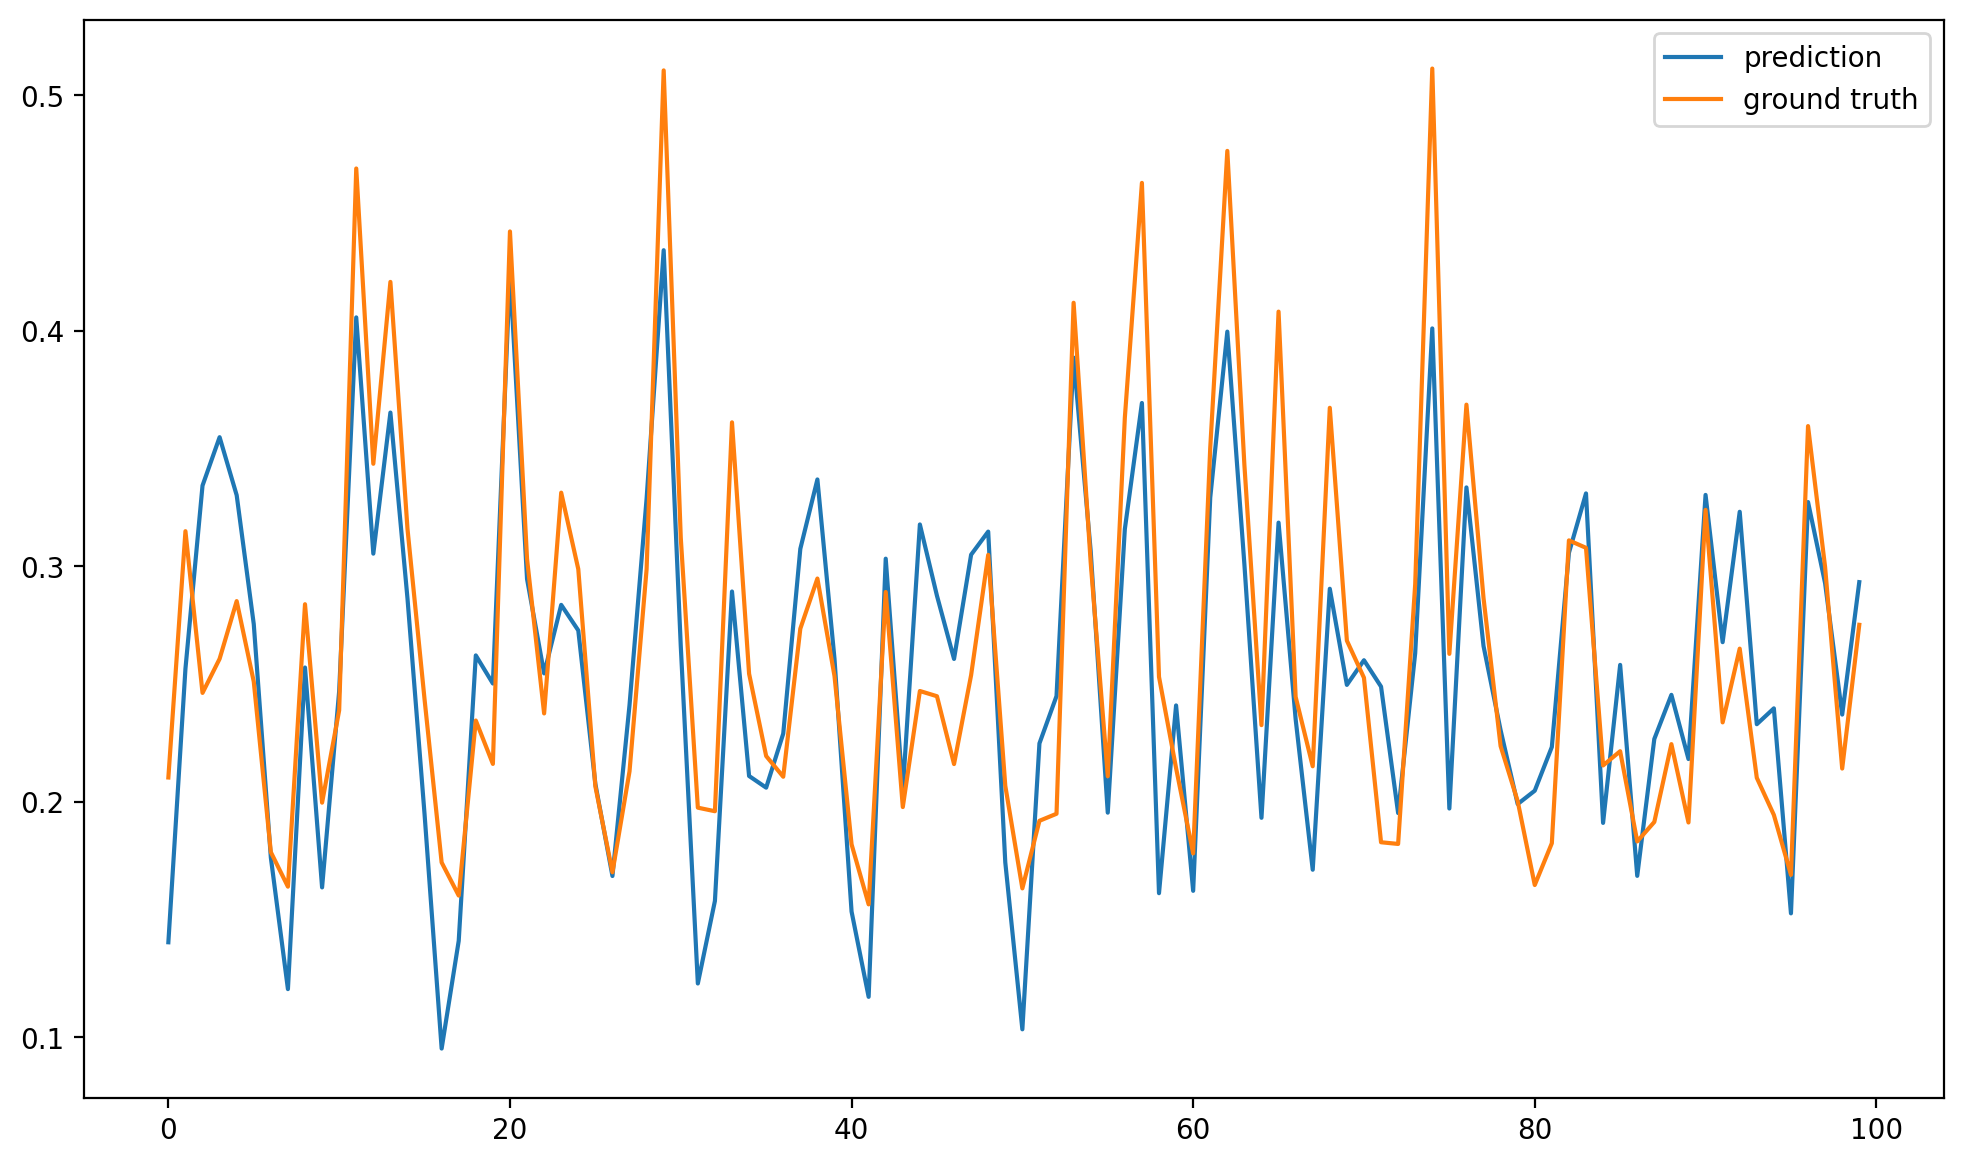

In [19]:
training_loop, history = train_RNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, 0)

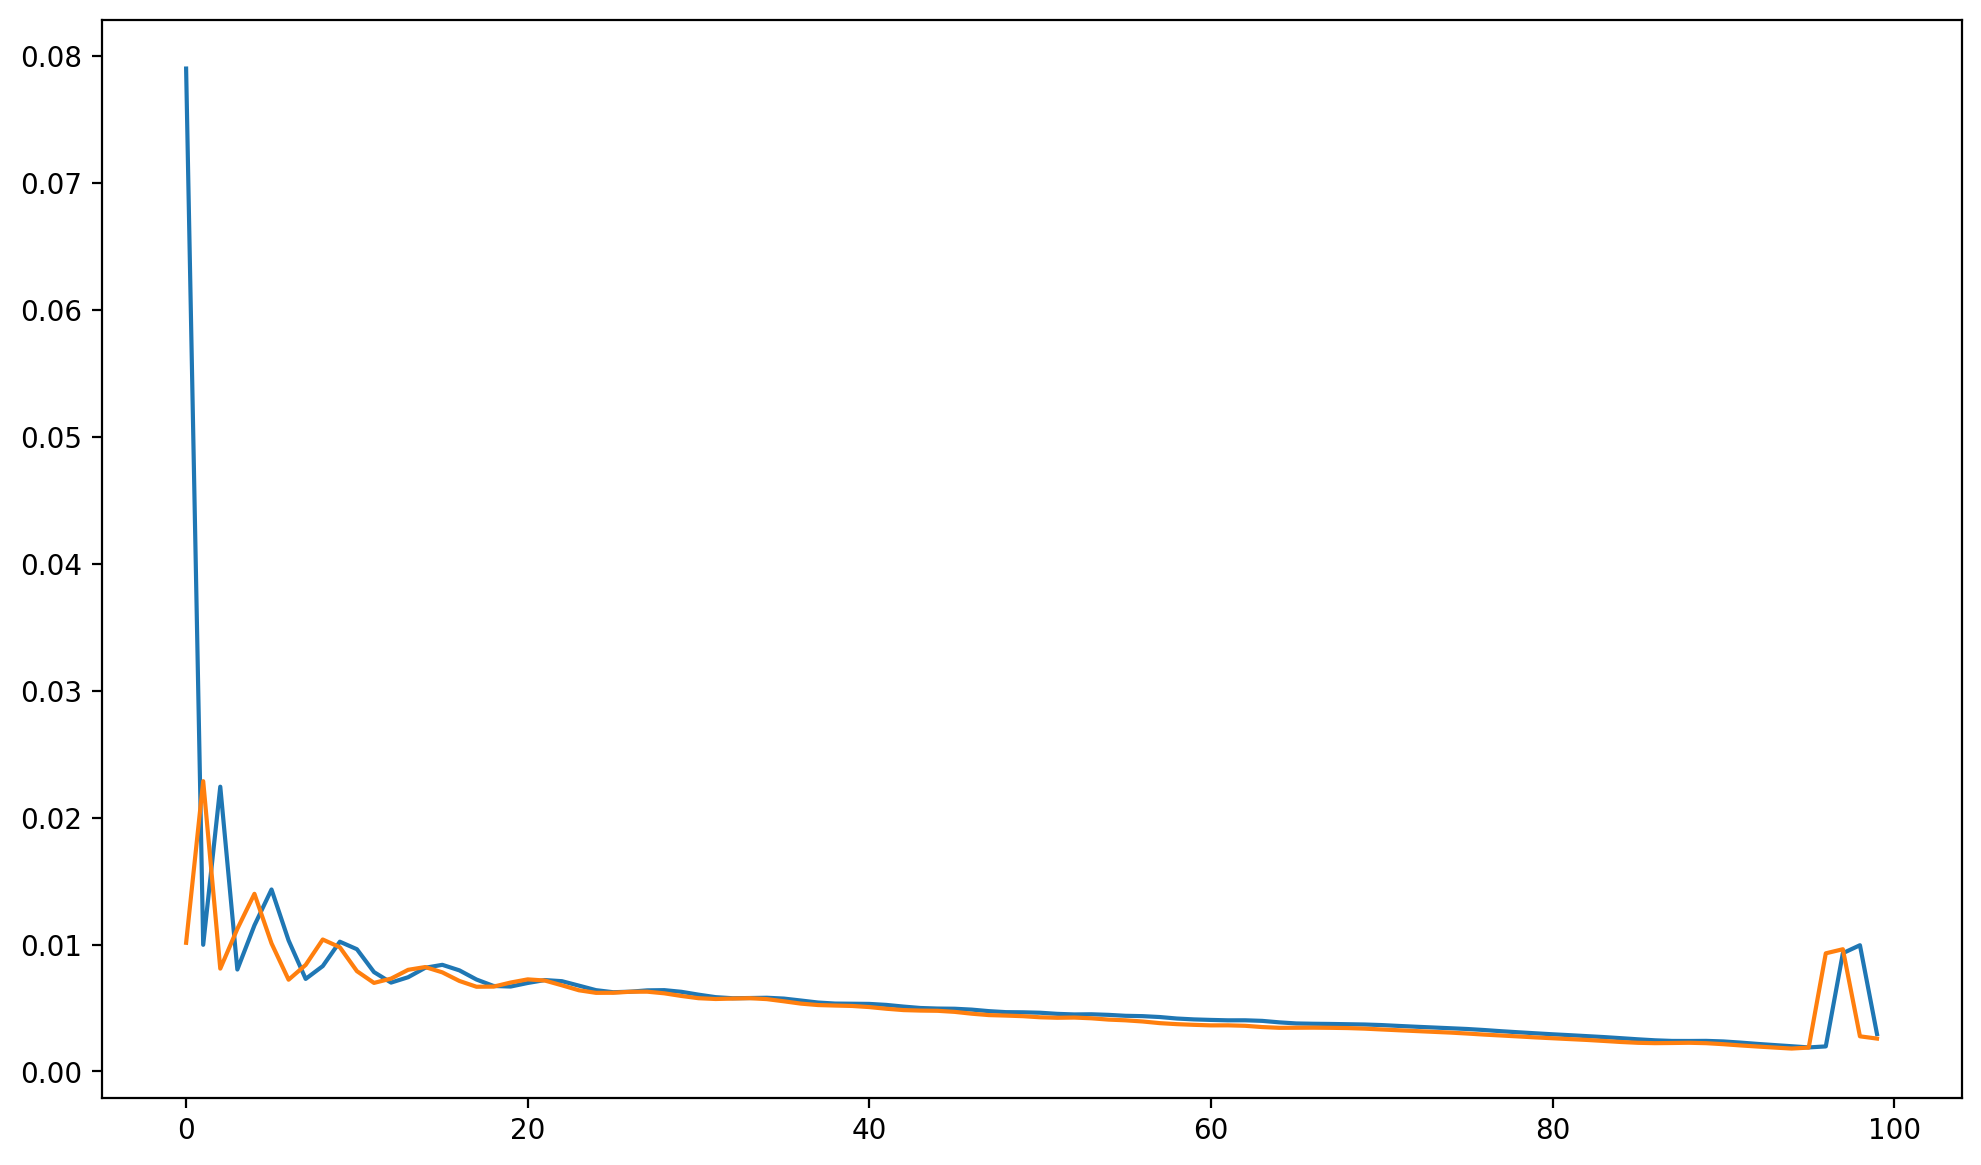

In [20]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.show()

# Bonus Track 1



In [21]:
df = pd.read_csv('./MG17.csv', header=None)
print(df.head())

       0         1         2         3        4        5        6        7      
0  0.032164  0.040426  0.057861  0.084015  0.11544  0.14572  0.16758  0.17624  \

      8        9     ...     9990     9991     9992     9993     9994   
0  0.17107  0.15465  ... -0.43905 -0.43957 -0.42772 -0.40213 -0.36305  \

      9995     9996     9997    9998      9999  
0 -0.31286 -0.25555 -0.19556 -0.1368 -0.082192  

[1 rows x 10000 columns]


### TDNN

In [22]:
device = 'cuda'
dataset = TensorDataset(torch.from_numpy(df.values[0, :-1]), torch.from_numpy(df.values[0, 1:]))

score_function = lambda config: train_TDNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(tdnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 246, 'lr': 0.0004297845477963858, 'epochs': 327}


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 667, 'lr': 0.00013338039655731506, 'epochs': 422}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 65, 'lr': 0.0005249097976883887, 'epochs': 366}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 277, 'lr': 0.00034015829080926406, 'epochs': 189}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 235, 'lr': 0.00011997878669055811, 'epochs': 249}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 79, 'lr': 0.00025838371731091064, 'epochs': 450}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 360, 'lr': 0.0004349733282676587, 'epochs': 271}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 176, 'lr': 0.0009364991435612784, 'epochs': 343}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 631, 'lr': 0.00011981247463755807, 'epochs': 415}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 438, 'lr': 0.00039109986222872045, 'epochs': 389}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 443, 'lr': 0.00012604534082194155, 'epochs': 433}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 787, 'lr': 0.00075868886535568, 'epochs': 482}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 782, 'lr': 0.0002776770054352653, 'epochs': 444}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 311, 'lr': 0.0008997866051417206, 'epochs': 475}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 458, 'lr': 0.0007057677382978018, 'epochs': 356}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 3, 'dim': 812, 'lr': 0.0006087453704662759, 'epochs': 180}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 618, 'lr': 0.00020650432758780786, 'epochs': 414}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 391, 'lr': 0.0008047916950296061, 'epochs': 221}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 906, 'lr': 0.00017732828244089165, 'epochs': 205}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 563, 'lr': 0.0005591964547762287, 'epochs': 423}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 5, 'dim': 949, 'lr': 0.0006262190985947702, 'epochs': 405}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 1010, 'lr': 0.0002033131811739468, 'epochs': 440}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 2, 'dim': 101, 'lr': 0.00032590493743044036, 'epochs': 423}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 439, 'lr': 0.0006353763439358935, 'epochs': 394}


Evaluating configuration: {'window': 15, 'verbose': 0, 'num_layers': 1, 'dim': 788, 'lr': 0.0004455186912616624, 'epochs': 172}


Best configuration found: {'window': 15, 'verbose': 0, 'num_layers': 4, 'dim': 787, 'lr': 0.00075868886535568, 'epochs': 482}
 with error: 2.7643923203868326e-06


Test loss: 2.1857131287106313e-06


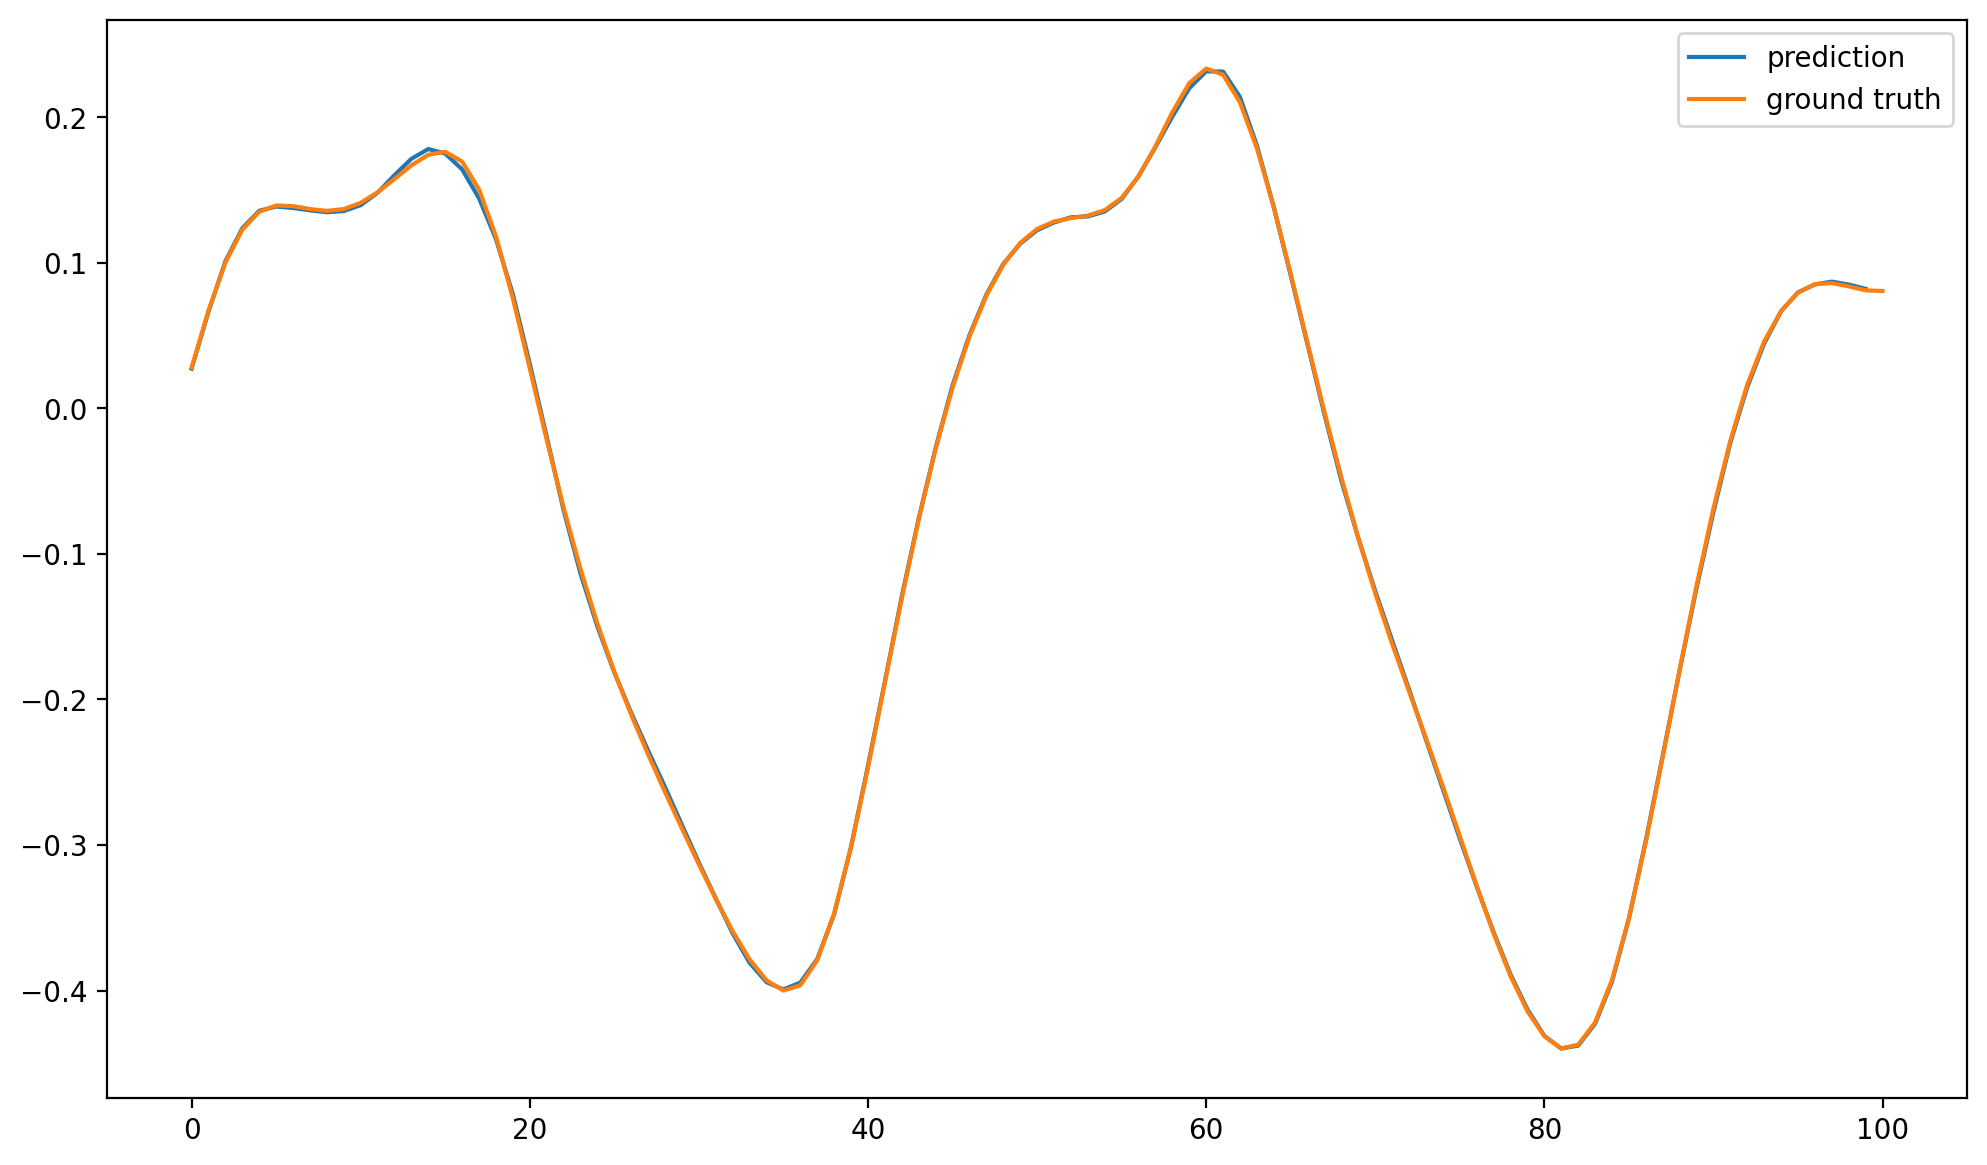

In [23]:
training_loop, history = train_TDNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, best_config['window'])

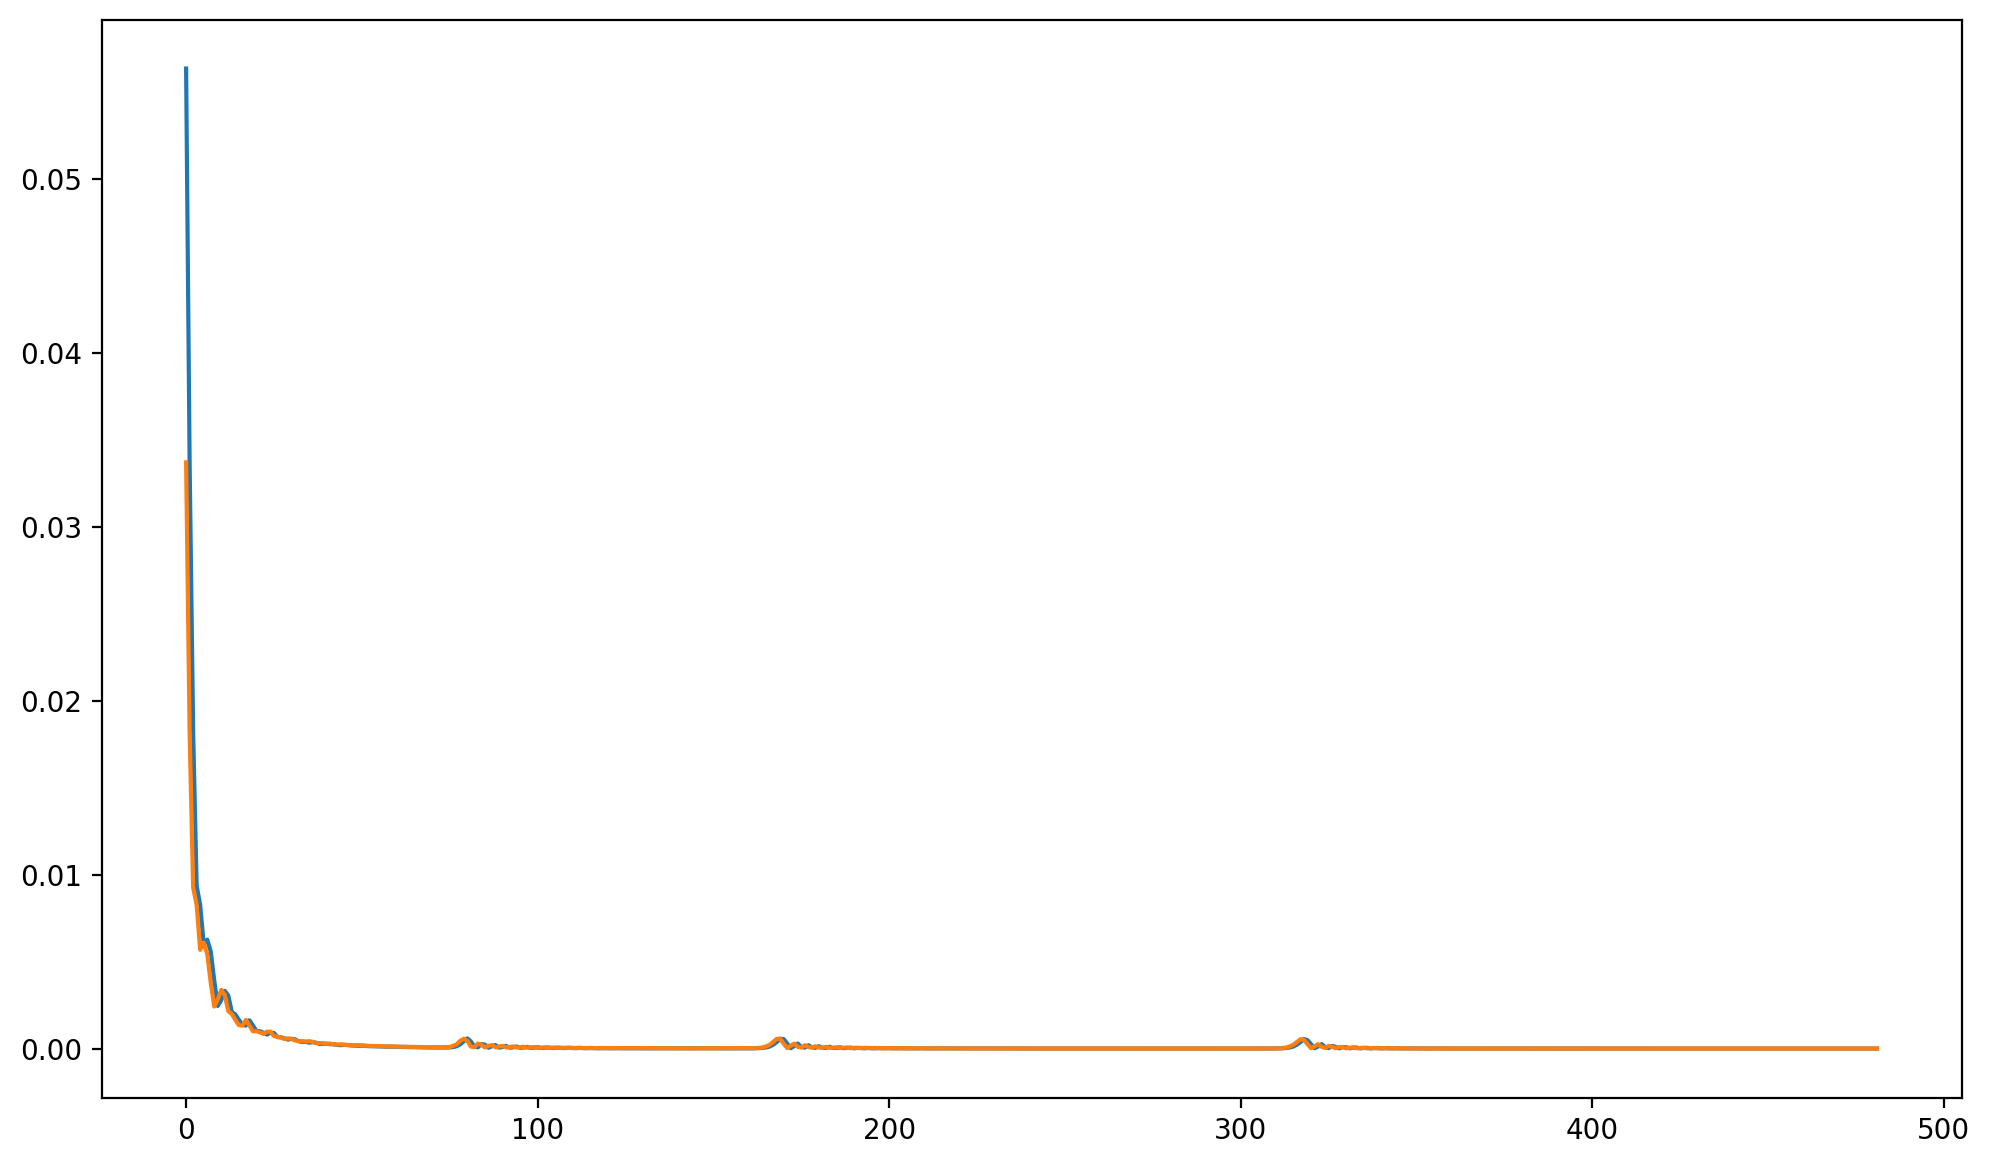

In [24]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.show()

### RNN



In [25]:
device = 'cuda'
score_function = lambda config: train_RNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(rnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 188}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 33}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 227}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 75}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 60}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 25}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 43}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 184}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 121}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 129}


Best configuration found: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 227}
 with error: 0.00010690188355511054


Test loss: 0.00012238982890266925


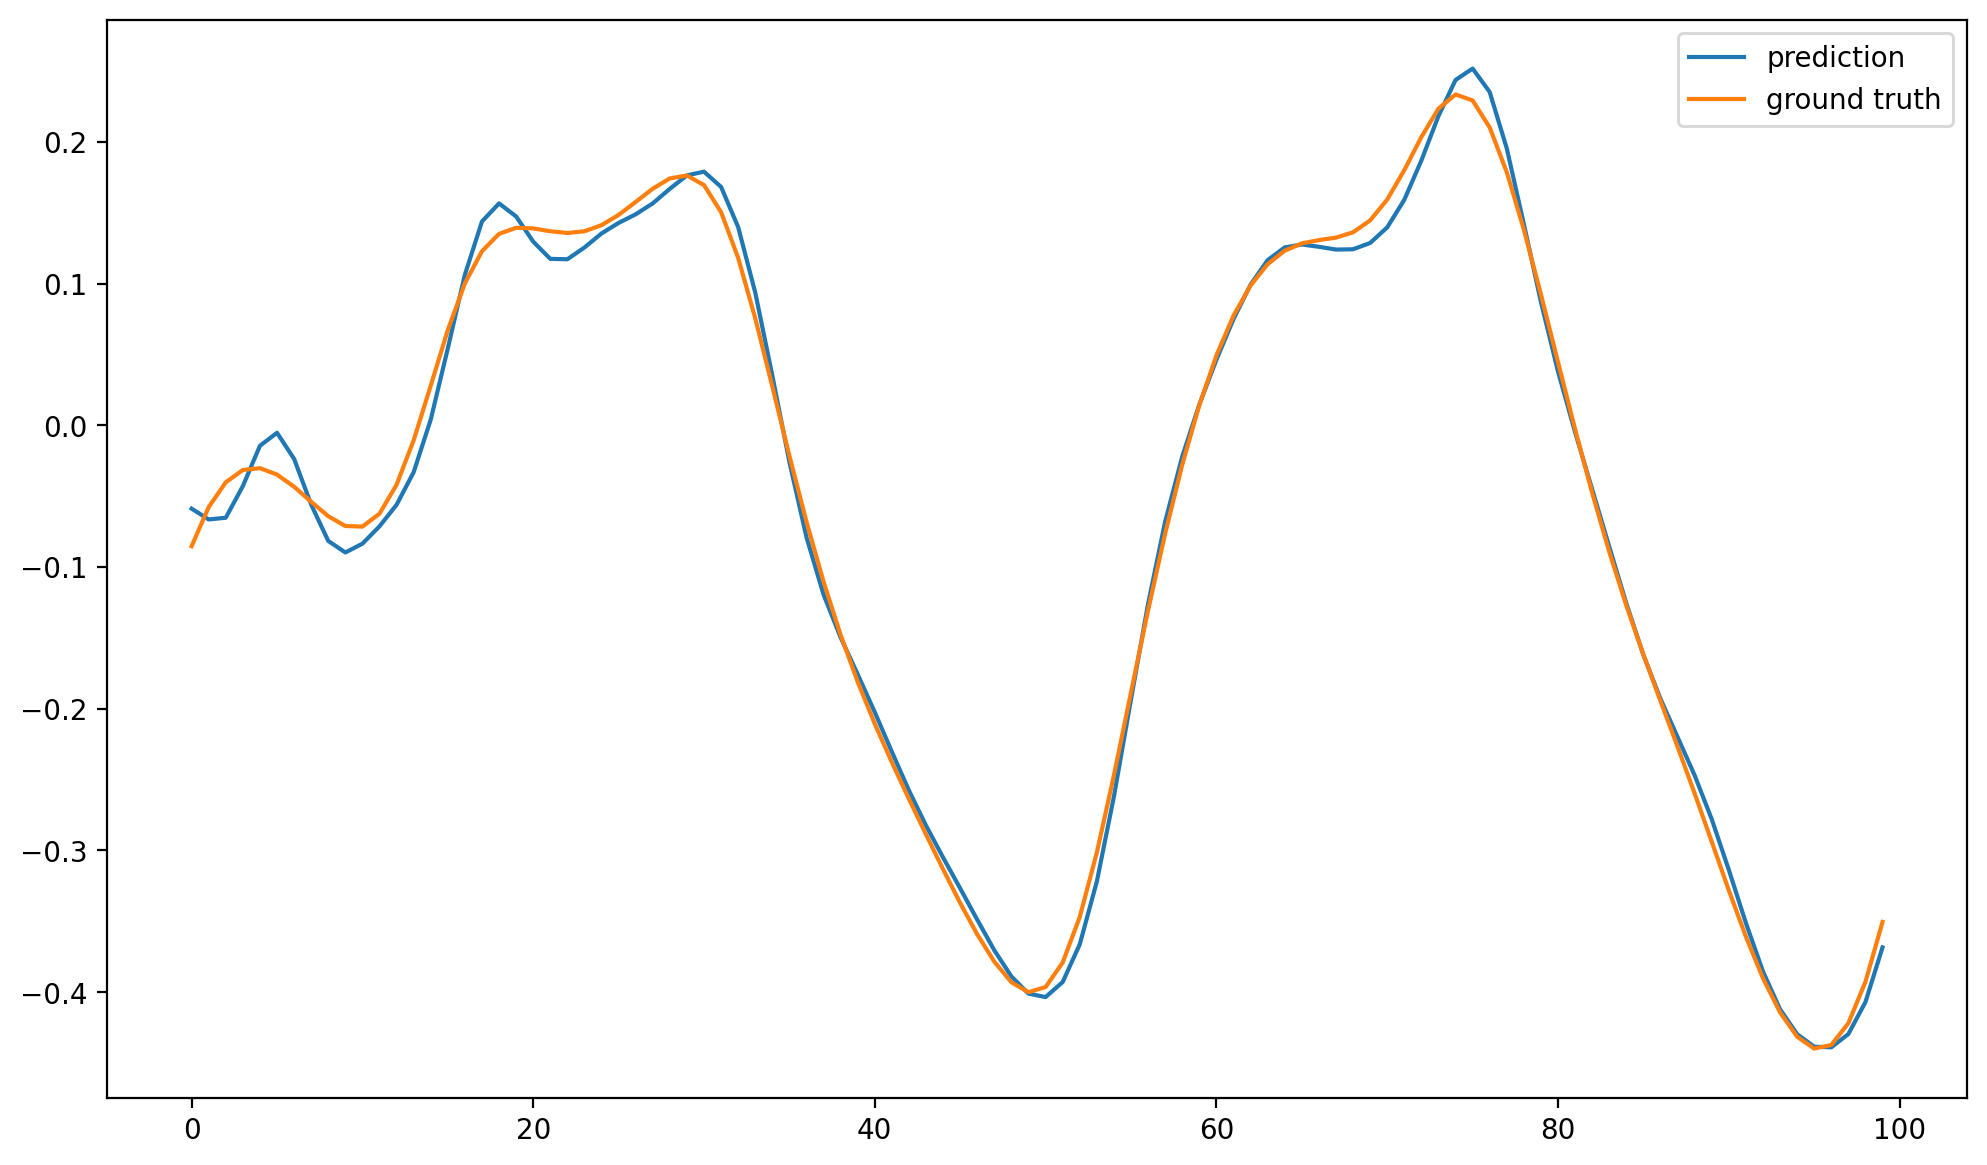

In [26]:
training_loop, history = train_RNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, 0)

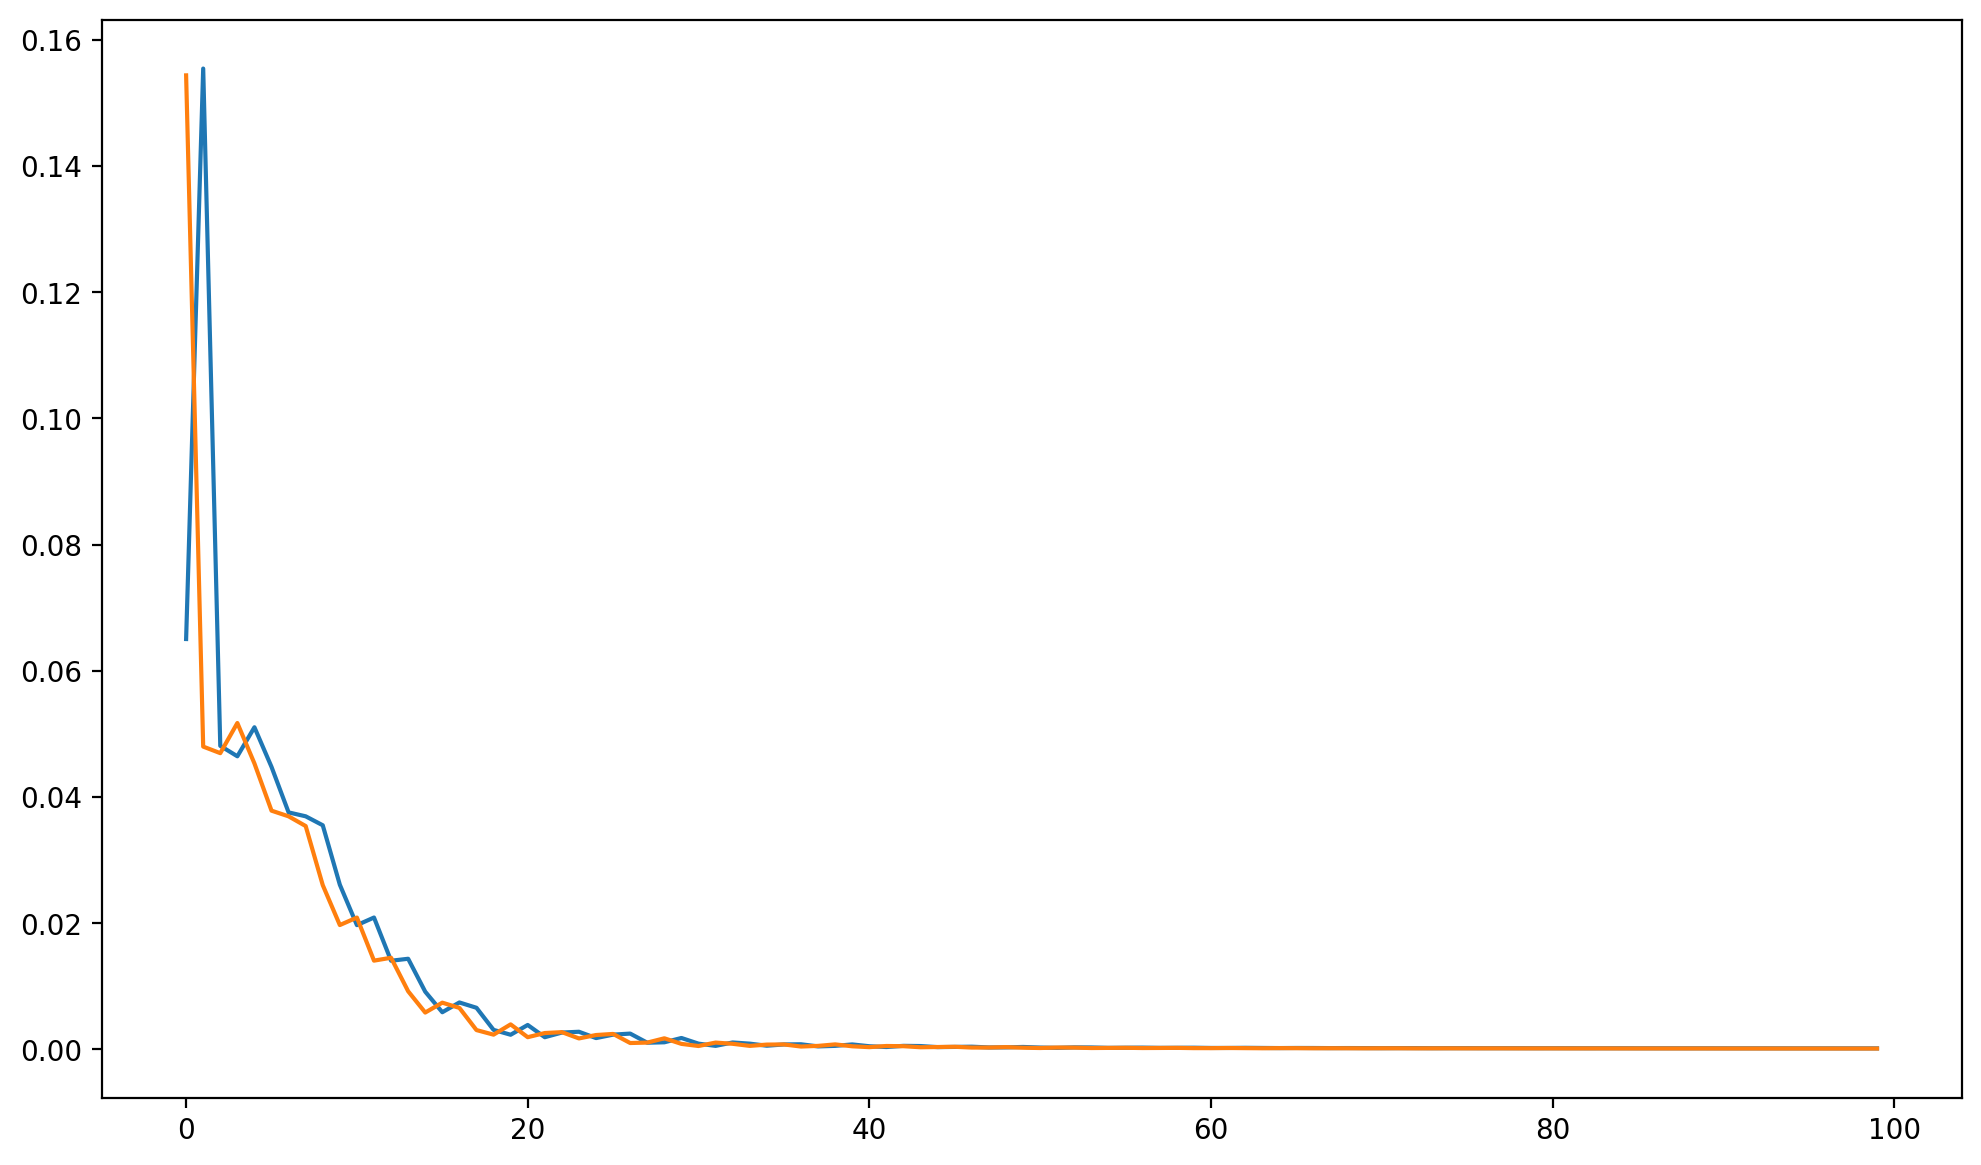

In [27]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.show()